# Poisson Neuron Model
This model treats each neuron as a Poisson process, with the expected number of firing events per timestep is controlled by a per-cell parameter $f$. The Poisson distribution is not an ideal choice because of refractory periods, depression, and other such effects which mean that spikes are not independent, but hopefully it is a useful first pass.

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import scipy.optimize as spo
import functools

In [2]:
Tmax = 100000
Ncells = 500
sigma = 0.5

fspike = np.random.lognormal(mean=np.log(40/1000) - sigma**2/2, sigma=sigma, size=Ncells)

Sij = np.random.normal(loc=0.001, scale=0.001, size=(Ncells,Ncells))
np.fill_diagonal(Sij, -0.5)

In [3]:
%%time
firings = np.zeros((Tmax+1, Ncells), dtype=np.int)
fspikes = np.zeros((Tmax+1, Ncells))
fspikes[0,:] = fspike
for t in range(Tmax):
    firings[t,:] = np.random.poisson(lam=fspikes[t,:], size=Ncells)
    fspikes[t+1,:] = 2*sigmoid(Sij @ firings[t,:]) * fspikes[t,:]
firings[t,:] = np.random.poisson(lam=fspikes[t,:], size=Ncells)

CPU times: user 24.7 s, sys: 2.88 s, total: 27.6 s
Wall time: 6.96 s


In [25]:
ff = firings[8000:9000,:]
events = []
for t in range(ff.shape[0]):
    for n in range(ff.shape[1]):
        if ff[t,n] > 0:
            events.append((t,n))
events = np.array(events)

<IPython.core.display.Javascript object>


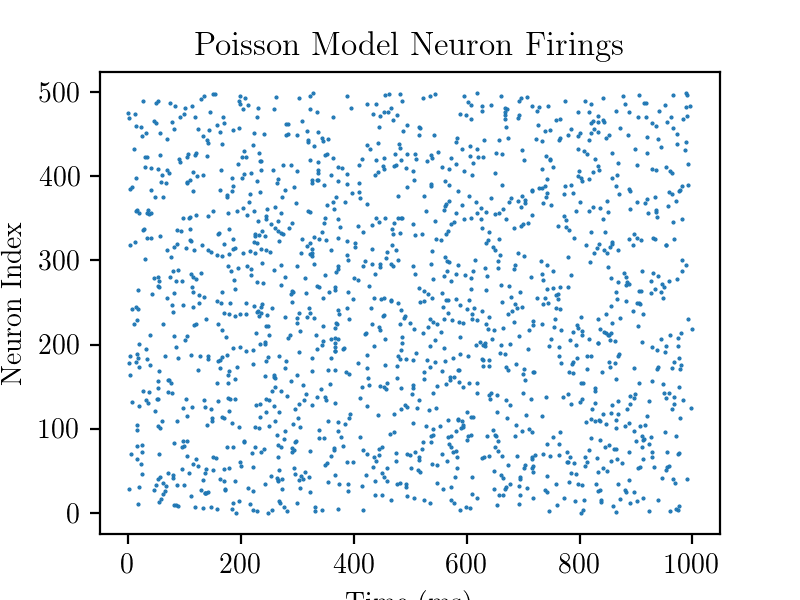

Text(0, 0.5, 'Neuron Index')

In [28]:
plt.figure(figsize=(4,3))
plt.plot(events[:,0], events[:,1], 
         '.', markersize=1, label='excitatory')
plt.title('Poisson Model Neuron Firings')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')

In [4]:
def firingrate_curve(firings):
    means = firings.mean(axis=1)
    ts = np.arange(len(means))
    
    def evaluate(params, ts):
        return params[2] + params[0] * np.exp(-params[1]**2 * ts)

    def objective(params):
        vals = evaluate(params, ts)
        squares = (vals - means)**2
        return squares.sum()

    res = spo.fmin(objective, [1,1,0])
    print(f'\tTime Constant: {res[1]**-2 / 1000:0.2}s')
    print(f'\tBasal Firing Rate: {res[2]*1000:0.2}Hz')
    return functools.partial(evaluate, res)


In [13]:
curve = firingrate_curve(firings)(range(Tmax))
means = firings.mean(axis=1)

Optimization terminated successfully.
         Current function value: 0.365897
         Iterations: 142
         Function evaluations: 258
	Time Constant: 2.6s
	Basal Firing Rate: 0.82Hz
	Alternately, 0.3Hz


<IPython.core.display.Javascript object>


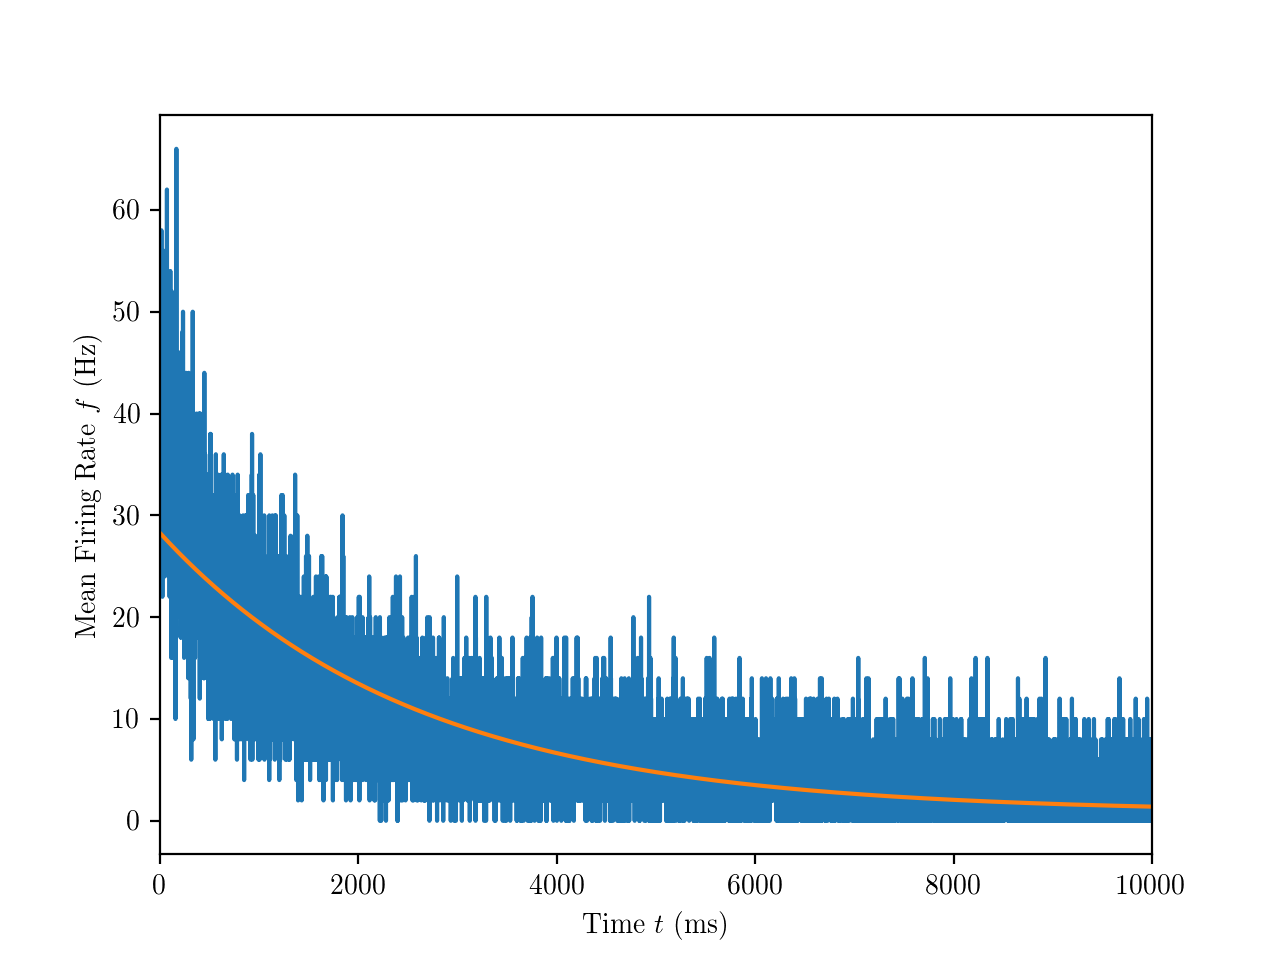

(0, 10000)

In [14]:
plt.figure()
plt.plot(1000*means)
plt.plot(1000*curve)
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Mean Firing Rate $f$ (Hz)')
plt.xlim(0,10000)